 # ShipSet Model Training

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import glob
import PIL
import PIL.Image as Image
import tqdm
import time
import os
import random

import sklearn.model_selection

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision
import matplotlib.pyplot as plt

# Config

In [2]:
N_FOLDS=5

TRAIN_BATCH_SIZE=4
TEST_BATCH_SIZE=4

CRITERION=torch.nn.CrossEntropyLoss()

EPOCHS=10

OPTIMIZER="SGD"
OPTIMIZER_PARAMS={"lr":0.01,"momentum":0.9}

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

MODEL_SAVE_DIR="models"

EARLY_STOP=3 #after this many epochs, early stop if no improvement has happened
SEED=42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

In [3]:
os.makedirs(MODEL_SAVE_DIR,exist_ok=True)

# Load Dataset

In [4]:
f = open("Data\shipsnet.json")
 
# returns JSON object as
# a dictionary
dataset = json.load(f)


In [5]:
Images=np.reshape(np.array(dataset['data']),(4000,3,80,80)).astype('uint8')


In [6]:
labels=np.array(dataset['labels'])

## Create Dataset

In [7]:
class ShipSet(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: a np array of the images
        labels: the labels for each image
        transforms: the transforms used to transform each image, this will be necessary because the
        dataset is very small, only 4,000 images
        """
        self.images=torch.from_numpy(images)
        self.labels=labels
        self.transform=transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,index):
        
        image=self.images[index]
        label=self.labels[index]
        
        if self.transform:
            image=self.transform(image)
        
        return image,label
        
        

As a test, lets have our custom dataset display some images, to do that let us write a function to display the images together as one matplotlib figure, this will also come in handy when we begin to experiment with transforms

In [8]:
def display_images(dataset, indexs):
    fig,axs=plt.subplots(ncols=len(indexs),figsize=(10,10*len(indexs)))
    
    for i, index in enumerate(indexs):
        image, label=dataset[index]
        axs[i].imshow(image.T.numpy())
        axs[i].axis('off')
        if label==1:
            axs[i].title.set_text("ship")
        else:
            axs[i].title.set_text("not ship")
        



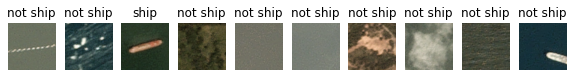

In [9]:
testSet=ShipSet(Images,labels)
display_images(testSet, np.random.choice(np.arange(len(testSet)),size=10))

# Writing the Train and Val Functions

In [10]:
def train_once(model,trainLoader,optimizer,
               criterion,device='cpu',
               print_loss=True,print_accuracy=True):
    
    start_time=time.time()
    total_loss=0
    n_correct=0
    n_total=0
    for batch in trainLoader:
        Images=batch[0].to(device)
        Labels=batch[1].to(device).long()
        #print(Labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(Images)
        loss = criterion(outputs, Labels)
        loss.backward()
        optimizer.step()
        
        #record loss and accuracy
        total_loss+=loss.item()
        n_correct=torch.sum(torch.argmax(outputs, axis=1)==Labels).item()
        n_total=Labels.shape[0]
    
    print(f"time:{round(time.time()-start_time,2)}s",end="|")
    if print_loss:
        print(f"train loss={round(total_loss/n_total,5)}",end="|")
    if print_accuracy:
        print(f"train accuracy={round(n_correct/n_total,4)}",end="|")
    

In [11]:
def val(model,valLoader,device="cpu"):
    
    label_true=[]
    label_pred=[]
    with torch.no_grad():
        for batch in valLoader:
            Images=batch[0].to(device)
            Labels=batch[1]
            # calculate outputs by running images through the network
            outputs = model(Images).cpu().detach()
            
            #record predictions and truths
            label_true+=Labels.tolist()
            label_pred+=torch.max(outputs.data, 1)[1].tolist()
    return label_true,label_pred

# Helper functions to create the model and optimizer

In [12]:
def create_model():
    model=torchvision.models.resnet18(pretrained=False)
    model.fc=torch.nn.Linear(512,2)
    return model

In [13]:
def create_optimizer(model,optimizer_name,optimizer_params):
    if optimizer_name=="SGD":
        return optim.SGD(model.parameters(),**optimizer_params)

# Create Transforms

Because the dataset is so small we will have to transform the dataset. To do this I will be using the transforms found in the torchvision.transforms library

In [14]:
transform=T.Compose([
    T.RandomRotation(180),
    T.ConvertImageDtype(torch.float32)
])

To understand how this would alter the images, let us plot a sample of untransformed and transformed images

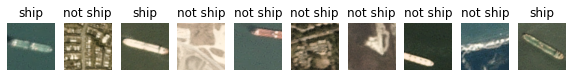

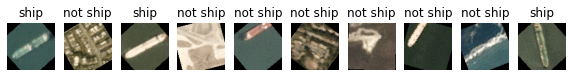

In [15]:
testSetTransfom=ShipSet(Images,labels,transform=transform)
indexs=np.random.choice(np.arange(len(testSet)),size=10)
display_images(testSet, indexs)
display_images(testSetTransfom, indexs)

# Main Routine

In [18]:
def main():
    kf = sklearn.model_selection.KFold(n_splits=N_FOLDS,shuffle=True)
    fold=1
    OOF_Accuracy=0
    all_labels_true=[]
    all_labels_pred=[]
    for train_index, test_index in kf.split(labels):
        print(f"----------fold {fold}----------")
        trainSet=ShipSet(Images[train_index],labels[train_index],transform=transform)
        valSet=ShipSet(Images[test_index],labels[test_index],
                      transform=T.ConvertImageDtype(torch.float32))
        
        
        trainLoader=DataLoader(trainSet, batch_size=TRAIN_BATCH_SIZE,shuffle=True)
        valLoader=DataLoader(valSet, batch_size=TEST_BATCH_SIZE)
        
        model=create_model()
        model.to(DEVICE)
        optimizer=create_optimizer(model,OPTIMIZER,OPTIMIZER_PARAMS)
        
        best_accuracy=0
        epochs_without_improvment=0
    
        
        
        for epoch in range(EPOCHS):
            print(f"epoch {epoch+1}",end=" ")
            train_once(model,trainLoader,optimizer,
               CRITERION,device=DEVICE)
            
            label_true,label_pred=val(model,valLoader,device=DEVICE)
            
            
            accuracy=sklearn.metrics.accuracy_score(label_true, label_pred)
            print(f"val accuracy={accuracy}")
            
            epochs_without_improvment+=1
            if accuracy>best_accuracy:
                best_accuracy=accuracy
                torch.save(model,f'{MODEL_SAVE_DIR}/fold{fold}.pt')
                epochs_without_improvment=0
                best_epoch=epoch+1
                best_pred_labels=label_pred
                
            if epochs_without_improvment==EARLY_STOP:
                print(f"early stopping because the val accuracy has not improved for {EARLY_STOP} epochs")
                break
        print(f"best val accuracy was {best_accuracy} on epoch {best_epoch}")
        OOF_Accuracy+=best_accuracy/N_FOLDS
        fold+=1
        
        
        #plot out some example images from the val dataset:
        indexs=np.random.choice(np.arange(len(valSet)),size=10)
        fig,axs=plt.subplots(ncols=len(indexs),figsize=(30,30*len(indexs)))
        for i,index in enumerate(indexs):
            image,correct_label=valSet[index]
            axs[i].imshow(image.T.numpy())
            correct="ship"
            if correct_label==0:
                correct="not ship"
            predicted="ship"
            if best_pred_labels[index]==0:
                predicted="not ship"
            
            axs[i].title.set_text(f"predicted: {predicted}\n ground truth: {correct}")
        plt.show()
        plt.savefig(f"fold{fold}.png")
        
        all_labels_true+=label_true
        all_labels_pred+=best_pred_labels
    print(f"the OOF Accuracy was {OOF_Accuracy}")
    return all_labels_true,all_labels_pred
        
        
        
        
        
    

----------fold 1----------
epoch 1 time:14.13s|train loss=158.48179|train accuracy=1.0|val accuracy=0.74
epoch 2 time:13.96s|train loss=37.2693|train accuracy=1.0|val accuracy=0.82
epoch 3 time:13.79s|train loss=38.27831|train accuracy=1.0|val accuracy=0.945
epoch 4 time:13.91s|train loss=30.33347|train accuracy=1.0|val accuracy=0.90875
epoch 5 time:14.61s|train loss=17.98471|train accuracy=1.0|val accuracy=0.91875
epoch 6 time:14.48s|train loss=19.70662|train accuracy=1.0|val accuracy=0.895
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.945 on epoch 3


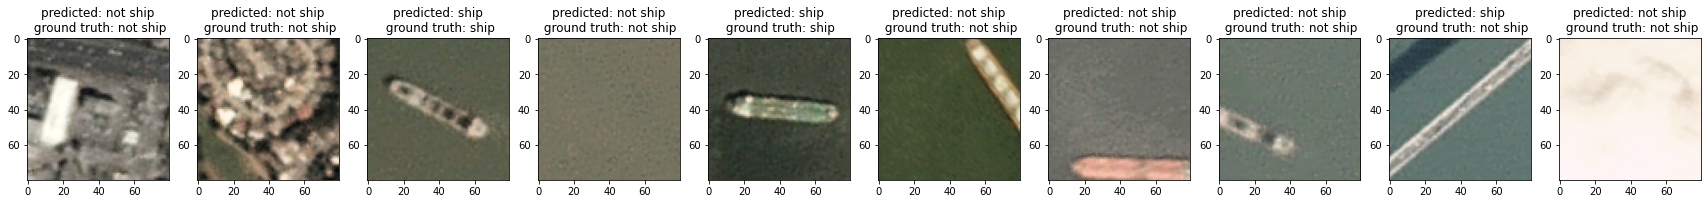

----------fold 2----------
epoch 1 time:14.09s|train loss=129.81307|train accuracy=1.0|val accuracy=0.78875
epoch 2 time:14.77s|train loss=37.92227|train accuracy=1.0|val accuracy=0.8625
epoch 3 time:13.52s|train loss=27.88829|train accuracy=1.0|val accuracy=0.835
epoch 4 time:13.85s|train loss=25.97618|train accuracy=1.0|val accuracy=0.92625
epoch 5 time:13.85s|train loss=23.28723|train accuracy=1.0|val accuracy=0.96875
epoch 6 time:14.64s|train loss=18.58683|train accuracy=1.0|val accuracy=0.9525
epoch 7 time:14.7s|train loss=16.02755|train accuracy=1.0|val accuracy=0.9675
epoch 8 time:14.49s|train loss=10.43214|train accuracy=1.0|val accuracy=0.96875
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.96875 on epoch 5


<Figure size 432x288 with 0 Axes>

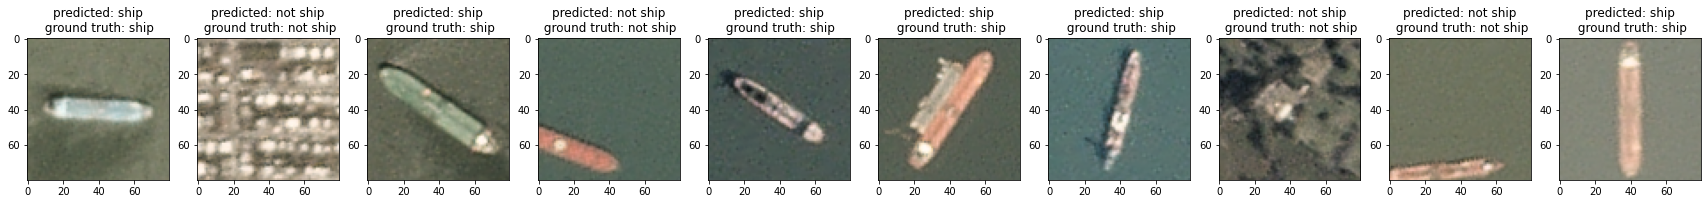

----------fold 3----------
epoch 1 time:14.26s|train loss=128.79844|train accuracy=1.0|val accuracy=0.7925
epoch 2 time:13.5s|train loss=48.63045|train accuracy=1.0|val accuracy=0.7575
epoch 3 time:13.75s|train loss=36.7178|train accuracy=1.0|val accuracy=0.7575
epoch 4 time:13.38s|train loss=31.66814|train accuracy=1.0|val accuracy=0.91625
epoch 5 time:13.41s|train loss=23.06278|train accuracy=0.75|val accuracy=0.90875
epoch 6 time:13.39s|train loss=22.01367|train accuracy=0.75|val accuracy=0.88625
epoch 7 time:13.75s|train loss=20.08069|train accuracy=1.0|val accuracy=0.91875
epoch 8 time:13.49s|train loss=20.15804|train accuracy=1.0|val accuracy=0.94375
epoch 9 time:13.37s|train loss=13.84039|train accuracy=1.0|val accuracy=0.9525
epoch 10 time:13.67s|train loss=13.32489|train accuracy=1.0|val accuracy=0.94375
best val accuracy was 0.9525 on epoch 9


<Figure size 432x288 with 0 Axes>

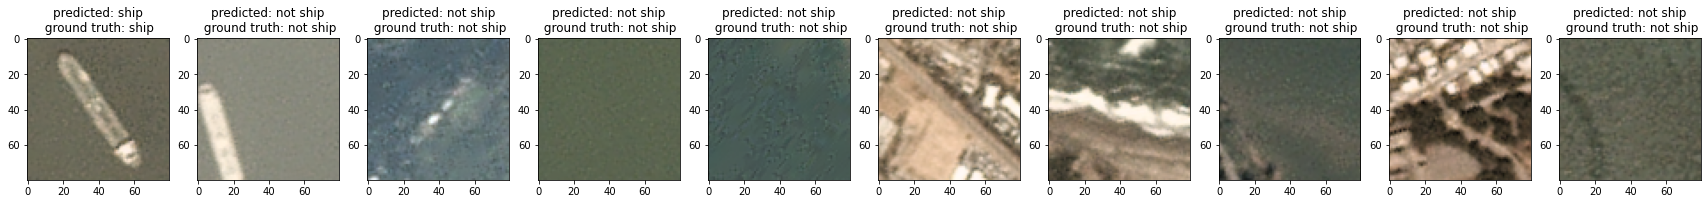

----------fold 4----------
epoch 1 time:14.07s|train loss=134.75323|train accuracy=0.75|val accuracy=0.815
epoch 2 time:15.55s|train loss=81.59631|train accuracy=0.75|val accuracy=0.875
epoch 3 time:14.34s|train loss=37.50928|train accuracy=1.0|val accuracy=0.76625
epoch 4 time:13.9s|train loss=30.20874|train accuracy=0.75|val accuracy=0.93
epoch 5 time:15.63s|train loss=21.43297|train accuracy=1.0|val accuracy=0.89
epoch 6 time:13.42s|train loss=23.39748|train accuracy=1.0|val accuracy=0.925
epoch 7 time:14.07s|train loss=21.64333|train accuracy=0.75|val accuracy=0.95625
epoch 8 time:14.54s|train loss=14.97049|train accuracy=1.0|val accuracy=0.9375
epoch 9 time:14.53s|train loss=15.54074|train accuracy=1.0|val accuracy=0.89125
epoch 10 time:13.42s|train loss=13.62375|train accuracy=1.0|val accuracy=0.88
early stopping because the val accuracy has not improved for 3 epochs
best val accuracy was 0.95625 on epoch 7


<Figure size 432x288 with 0 Axes>

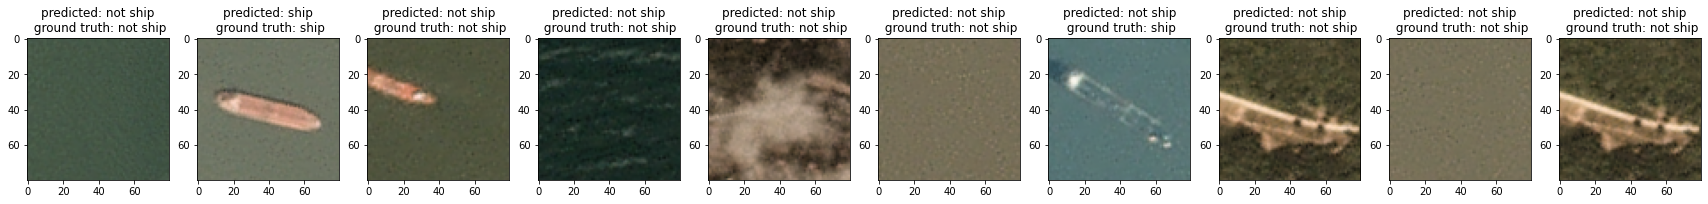

----------fold 5----------
epoch 1 time:14.88s|train loss=158.12143|train accuracy=1.0|val accuracy=0.78125
epoch 2 time:14.16s|train loss=33.82127|train accuracy=1.0|val accuracy=0.77875
epoch 3 time:14.51s|train loss=40.84619|train accuracy=1.0|val accuracy=0.93625
epoch 4 time:14.71s|train loss=39.04019|train accuracy=1.0|val accuracy=0.8075
epoch 5 time:14.06s|train loss=26.15517|train accuracy=1.0|val accuracy=0.9525
epoch 6 time:13.64s|train loss=22.92957|train accuracy=1.0|val accuracy=0.85
epoch 7 time:13.84s|train loss=23.66783|train accuracy=1.0|val accuracy=0.93125
epoch 8 time:13.74s|train loss=17.99654|train accuracy=1.0|val accuracy=0.98375
epoch 9 time:13.52s|train loss=17.62202|train accuracy=1.0|val accuracy=0.91875
epoch 10 time:13.56s|train loss=17.04246|train accuracy=1.0|val accuracy=0.91875
best val accuracy was 0.98375 on epoch 8


<Figure size 432x288 with 0 Axes>

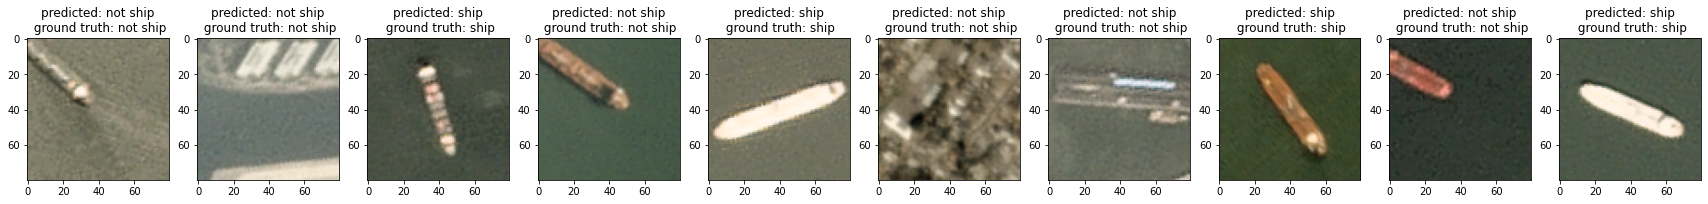

the OOF Accuracy was 0.96125


<Figure size 432x288 with 0 Axes>

In [19]:
labels_true,labels_pred=main()

We can also plot out the confusion matrix for the out of fold predictions

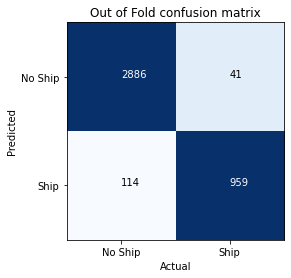

In [47]:
confusion_matrix=sklearn.metrics.confusion_matrix(labels_true,labels_pred)
plt.imshow(confusion_matrix/np.sum(confusion_matrix,axis=1),cmap='Blues')
for x in range(2):
    for y in range(2):
        color="black"
        if x==y:
            color="white"
        plt.text(x,y,confusion_matrix[x,y],color=color)

plt.xticks([0,1],["No Ship","Ship"])
plt.yticks([0,1],["No Ship","Ship"])
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.title("Out of Fold confusion matrix")
plt.show()